## Domain translation

In [1]:
# !pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.8.1"

### Setup imports

In [2]:
import random
from tqdm import trange
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
# from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import Dataset, DataLoader, partition_dataset
from monai.networks import eval_mode
from monai.transforms import (
    Compose,
    EnsureTyped,
    LoadImaged,
    MapTransform,
    rescale_array,
    ScaleIntensityd,
)
from monai.utils import set_determinism
import tempfile
print_config()
set_determinism(0)

MONAI version: 0.8.1
Numpy version: 1.21.2
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: 0.4.12
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.12.0
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## 1. Setting up our Dataset and exploring the data
#### Setup data directory

We'll create a temporary directory for all the MONAI data we're going to be using called temp directory in `~/monai-lab/temp`. 

In [3]:
import os 
directory = "../temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

../temp


In [4]:
# resource = "https://drive.google.com/uc?id=17f4J_rU5pi1zRmxMe5OwljyT3tlBf6qI&confirm=no_antivirus"
data_dir = os.path.join("../brain_2d")
# compressed_file = os.path.join("brain_2d.tar.gz")

### visualize dataset

In [5]:
input_ims = sorted(glob(os.path.join(data_dir, "*input.npy")))
output_ims = sorted(glob(os.path.join(data_dir, "*GT_output.npy")))
data = [{"input": i, "output": o} for i, o in zip(input_ims, output_ims)]
print("number data points", len(data))
print("example", data[0])

number data points 7500
example {'input': '../brain_2d/0_input.npy', 'output': '../brain_2d/0_GT_output.npy'}


In [6]:
data_sample = np.load('../brain_2d/0_input.npy')
gt_sample = np.load('../brain_2d/0_GT_output.npy')

In [7]:
print("data shape:", data_sample.shape, gt_sample.shape)

data shape: (3, 240, 240) (1, 240, 240)


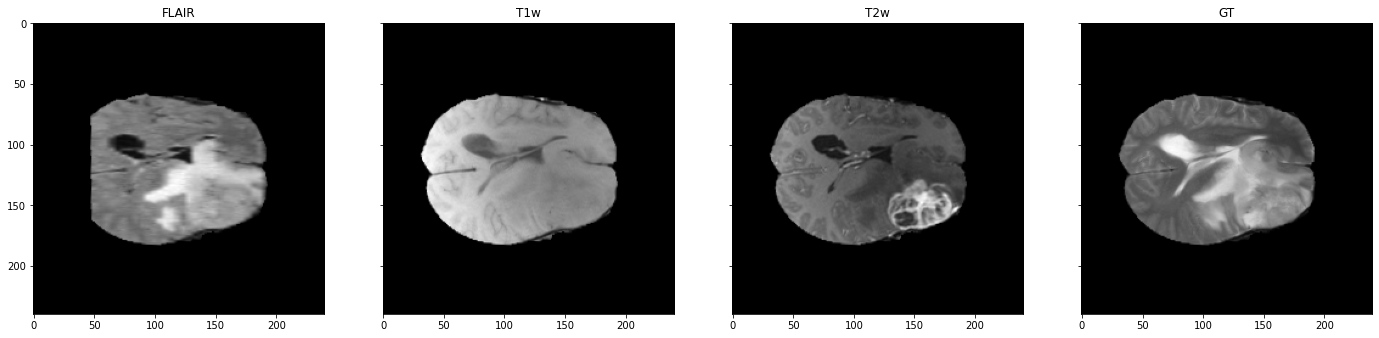

In [8]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4 ,  sharex=True, sharey=True, figsize=(24,6))

ax1.imshow(data_sample[0], cmap='gray' )
ax1.set_title('FLAIR')
ax2.imshow(data_sample[1], cmap='gray' )
ax2.set_title('T1w')
ax3.imshow(data_sample[2], cmap='gray' )
ax3.set_title('T2w')
ax4.imshow(gt_sample[0], cmap='gray' )
ax4.set_title('GT')
plt.show()


## split dataset( train / valid 20%)

In [9]:
class ChannelWiseScaleIntensityd(MapTransform):
    """Perform channel-wise intensity normalisation."""
    def __init__(self, keys):
        super().__init__(keys)
    def __call__(self, d):
        for key in self.keys:
            for idx, channel in enumerate(d[key]):
                d[key][idx] = rescale_array(channel)
        return d

keys = ["input", "output"]
train_transforms = Compose([
    LoadImaged(keys),
    ChannelWiseScaleIntensityd("input"),
    ScaleIntensityd("output"),
    EnsureTyped(keys),
])
val_transforms = Compose([
    LoadImaged(keys),
    ChannelWiseScaleIntensityd("input"),
    ScaleIntensityd("output"),
    EnsureTyped(keys),
])

t = train_transforms(data[0])
print(t["input"].shape, t["output"].shape)
in_channels, out_channels = t["input"].shape[0], t["output"].shape[0]

torch.Size([3, 240, 240]) torch.Size([1, 240, 240])


In [10]:
# split data into 80% and 20% for training and validation, respectively
train_data, val_data = partition_dataset(data, (8, 2), shuffle=True)
print("num train data points:", len(train_data))
print("num val data points:", len(val_data))
batch_size = 40 ##### default 10 1GB, AE : 40 2GiB
train_ds = Dataset(train_data, train_transforms)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_ds = Dataset(val_data, val_transforms)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

num train data points: 6000
num val data points: 1500


In [11]:
def imshows(ims):
    """Visualises a list of dictionaries.

    Each key of the dictionary will be used as a column, and
    each element of the list will be a row.
    """
    nrow = len(ims)
    ncol = len(ims[0])
    fig, axes = plt.subplots(nrow, ncol, figsize=(
        ncol * 4, nrow * 4), facecolor='white')
    for i, im_dict in enumerate(ims):
        for j, (title, im) in enumerate(im_dict.items()):
            if isinstance(im, torch.Tensor):
                im = im.detach().cpu().numpy()
            # If RGB, put to end. Else, average across channel dim
            if im.ndim > 2:
                im = np.moveaxis(im, 0, -1) if im.shape[0] == 3 else np.mean(im, axis=0)

            ax = axes[j] if len(ims) == 1 else axes[i, j]
            ax.set_title(f"{title}\n{im.shape}")
            im_show = ax.imshow(im, cmap='gray')
            ax.axis("off")



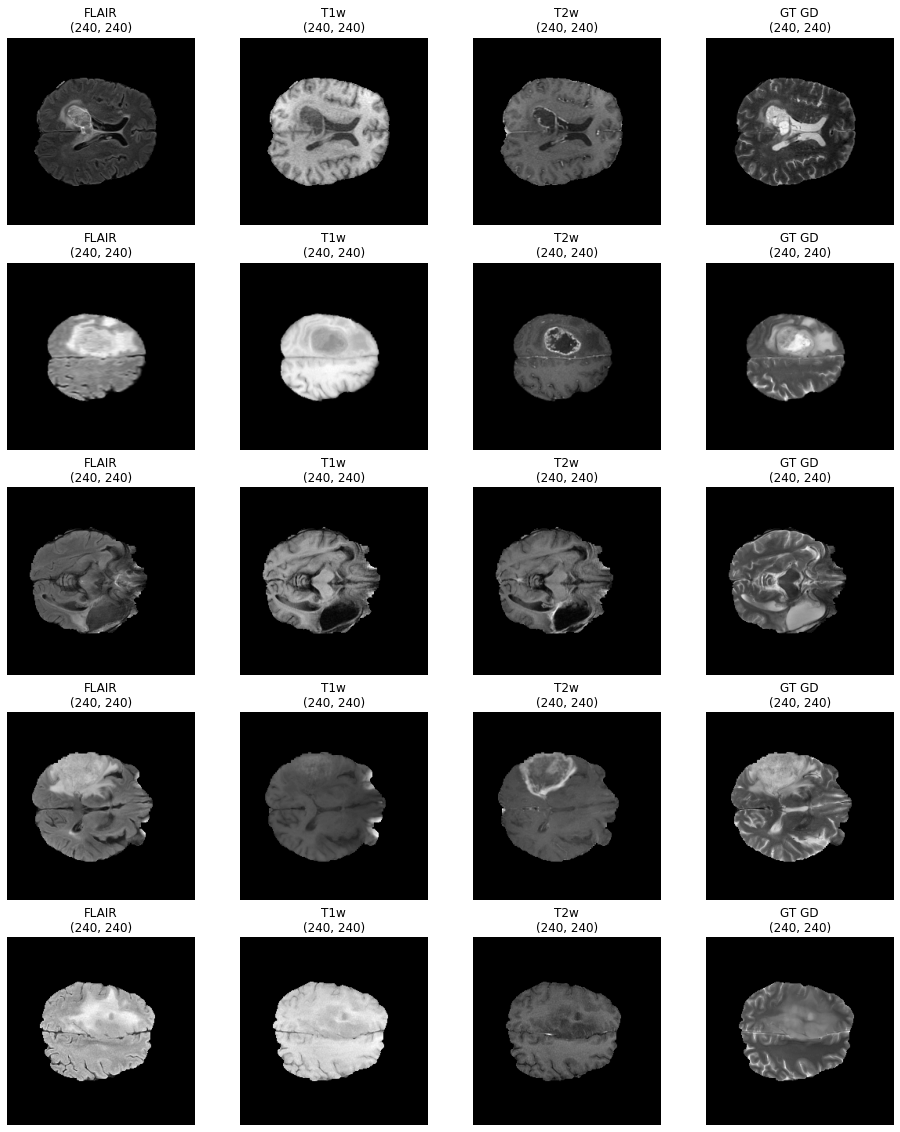

In [12]:
to_imshow = []
for idx in np.random.choice(len(val_ds), size=5, replace=False):
    rand_data = val_ds[idx]
    rand_input, rand_output_gt = rand_data["input"], rand_data["output"]

    to_imshow.append(
        {
            "FLAIR": rand_input[0],
            "T1w": rand_input[1],
            "T2w": rand_input[2],
            "GT GD": rand_output_gt,

        }
    )
imshows(to_imshow)

In [13]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 


### Template for train

#### configure model

In [14]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Create loss fn and optimiser

class Unet(torch.nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        
        self.down_pooling = torch.nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv_layer_1_1 = torch.nn.Conv2d(in_channels = 3,  out_channels = 32, kernel_size = 4, padding = (1,1))
        self.conv_layer_1_2 = torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 4, padding = (2,2))
        
        self.conv_layer_2_1 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 4, padding=(1,1))
        self.conv_layer_2_2 = torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 4, padding=(2,2))
        
        self.conv_layer_3_1 = torch.nn.Conv2d(in_channels = 64,  out_channels = 128, kernel_size = 4, padding=(1,1))
        self.conv_layer_3_2 = torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 4, padding=(2,2))
        
        self.conv_layer_4_1 = torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, padding=(1,1))
        self.conv_layer_4_2 = torch.nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 4, padding=(2,2))
        
        self.deconv_layer_3 = torch.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        
        self.concat_conv_layer_3_1 = torch.nn.Conv2d(in_channels=256, out_channels=128, kernel_size=4, padding=(1,1))
        self.concat_conv_layer_3_2 = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4, padding=(2,2))
        
        self.deconv_layer_2 = torch.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        
        self.concat_conv_layer_2_1 = torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=4, padding=(1,1))
        self.concat_conv_layer_2_2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, padding=(2,2))
        
        self.deconv_layer_1 = torch.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, stride=2)
        
        self.concat_conv_layer_1_1 = torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=4, padding=(1,1))
        self.concat_conv_layer_1_2 = torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, padding=(2,2))
        
        self.output_layer = torch.nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=(1,1))
    
    def forward(self, x):
        
        x_encoded_1_1 = torch.nn.functional.relu(self.conv_layer_1_1(x))
        x_encoded_1_2 = torch.nn.functional.relu(self.conv_layer_1_2(x_encoded_1_1))
        x_down_pooling_1 = self.down_pooling(x_encoded_1_2)
        
        # print(x_down_pooling_1.shape)
        
        x_encoded_2_1 = torch.nn.functional.relu(self.conv_layer_2_1(x_down_pooling_1))
        x_encoded_2_2 = torch.nn.functional.relu(self.conv_layer_2_2(x_encoded_2_1))
        x_down_pooling_2 = self.down_pooling(x_encoded_2_2)
        
        # print(x_down_pooling_2.shape)
        
        x_encoded_3_1 = torch.nn.functional.relu(self.conv_layer_3_1(x_down_pooling_2))
        x_encoded_3_2 = torch.nn.functional.relu(self.conv_layer_3_2(x_encoded_3_1))
        x_down_pooling_3 = self.down_pooling(x_encoded_3_2)
        
        # print(x_down_pooling_3.shape)
        
        x_encoded_4_1 = torch.nn.functional.relu(self.conv_layer_4_1(x_down_pooling_3))
        x_encoded_4_2 = torch.nn.functional.relu(self.conv_layer_4_2(x_encoded_4_1))
        
        x_up_pooling_3 = self.deconv_layer_3(x_encoded_4_2)
        
        x_concat_3 = torch.concat((x_up_pooling_3, x_encoded_3_2), dim=1)
        
        # print("cat3 :",x_concat_3.shape)
        
        x_decoded_3_1 = torch.nn.functional.relu(self.concat_conv_layer_3_1(x_concat_3))
        x_decoded_3_2 = torch.nn.functional.relu(self.concat_conv_layer_3_2(x_decoded_3_1))
        
        x_up_pooling_2 = self.deconv_layer_2(x_decoded_3_2)
        
        x_concat_2 = torch.concat((x_up_pooling_2, x_encoded_2_2), dim=1)
        
        # print("cat2 :",x_concat_2.shape)
        
        x_decoded_2_1 = torch.nn.functional.relu(self.concat_conv_layer_2_1(x_concat_2))
        x_decoded_2_2 = torch.nn.functional.relu(self.concat_conv_layer_2_2(x_decoded_2_1))
        
        x_up_pooling_1 = self.deconv_layer_1(x_decoded_2_2)
        
        x_concat_1 = torch.concat((x_up_pooling_1, x_encoded_1_2), dim=1)
        
        # print("cat1: ",x_concat_1.shape)
        
        x_decoded_1_1 = torch.nn.functional.relu(self.concat_conv_layer_1_1(x_concat_1))
        x_decoded_1_2 = torch.nn.functional.relu(self.concat_conv_layer_1_2(x_decoded_1_1))
        
        output = self.output_layer(x_decoded_1_2)
        # print("output", output.shape)
        
        return output


model = Unet()
model.to(device)
print(model)

Unet(
  (down_pooling): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv_layer_1_1): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv_layer_1_2): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (conv_layer_2_1): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv_layer_2_2): Conv2d(64, 64, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (conv_layer_3_1): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv_layer_3_2): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (conv_layer_4_1): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (conv_layer_4_2): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (deconv_layer_3): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (concat_conv_layer_3_1): Conv2d(256, 128, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (concat_conv_layer_

In [15]:
# Create loss fn and optimiser

loss_function = torch.nn.MSELoss() # TODO

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), learning_rate)  # TODO


In [16]:
max_epochs = 100  #None  # TODO

It will take more 10 minutes to finish 20 epoch training. it depends on system.

In [17]:
%%time
epoch_losses = []

t = trange(max_epochs, desc=f"epoch 0, avg loss: - ", leave=True)
for epoch in t:
    model.train()
    epoch_loss = 0
    step = 0
    for batch in train_dl:
        step += 1
        inputs, outputs_gt = batch["input"].to(device), batch["output"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = loss_function(outputs, outputs_gt)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_losses.append(epoch_loss)
    t.set_description(f"epoch {epoch + 1}, average loss: {epoch_loss:.6f}")
    if (epoch+1) % 10 == 0: 
        torch.save(model.state_dict(), os.path.join(root_dir, "gan_ae1_model_{:04d}.pth".format(epoch+1)))
        torch.save(optimizer.state_dict(), os.path.join(root_dir, "gan_ae1_optim_{:04d}.pth".format(epoch+1)))
        #print("|{}ep model saved".format(epoch+1), end='')    

epoch 100, average loss: 0.000458: 100%|██████████| 100/100 [1:01:29<00:00, 36.89s/it]

CPU times: user 7h 32min 58s, sys: 1d 8h 36min 33s, total: 1d 16h 9min 31s
Wall time: 1h 1min 29s


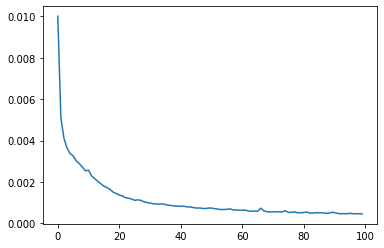

In [18]:
plt.plot(epoch_losses)
plt.show()

In [19]:
%matplotlib inline
def imshows(ims):
    """Visualises a list of dictionaries.

    Each key of the dictionary will be used as a column, and
    each element of the list will be a row.
    """
    nrow = len(ims)
    ncol = len(ims[0])
    fig, axes = plt.subplots(nrow, ncol, figsize=(
        ncol * 3, nrow * 3), facecolor='white')
    for i, im_dict in enumerate(ims):
        for j, (title, im) in enumerate(im_dict.items()):
            if isinstance(im, torch.Tensor):
                im = im.detach().cpu().numpy()
            # If RGB, put to end. Else, average across channel dim
            if im.ndim > 2:
                im = np.moveaxis(im, 0, -1) if im.shape[0] == 3 else np.mean(im, axis=0)

            ax = axes[j] if len(ims) == 1 else axes[i, j]
            ax.set_title(f"{title}\n{im.shape}")
            im_show = ax.imshow(im, cmap='gray')
            ax.axis("off")


def inference_gan(model, num_data=4):
    from statistics import mean
    to_imshow = []
    mse = []
    with torch.no_grad():    
        for idx in np.random.choice(len(val_ds), size=num_data, replace=False):
            rand_data = val_ds[idx]
            rand_input, rand_output_gt = rand_data["input"], rand_data["output"]
            rand_output = model(rand_input.to(device)[None])[0]
            to_imshow.append(
                {
                    "FLAIR": rand_input[0],
                    "T1w": rand_input[1],
                    "T2w": rand_input[2],
                    "GT GD": rand_output_gt,
                    "inferred GD": rand_output,
                }
            )
            loss = torch.nn.MSELoss()
            mse.append(loss(rand_output.to("cpu"),rand_output_gt).item())
    imshows(to_imshow)
    print(mean(mse))

0.0009714740808703937


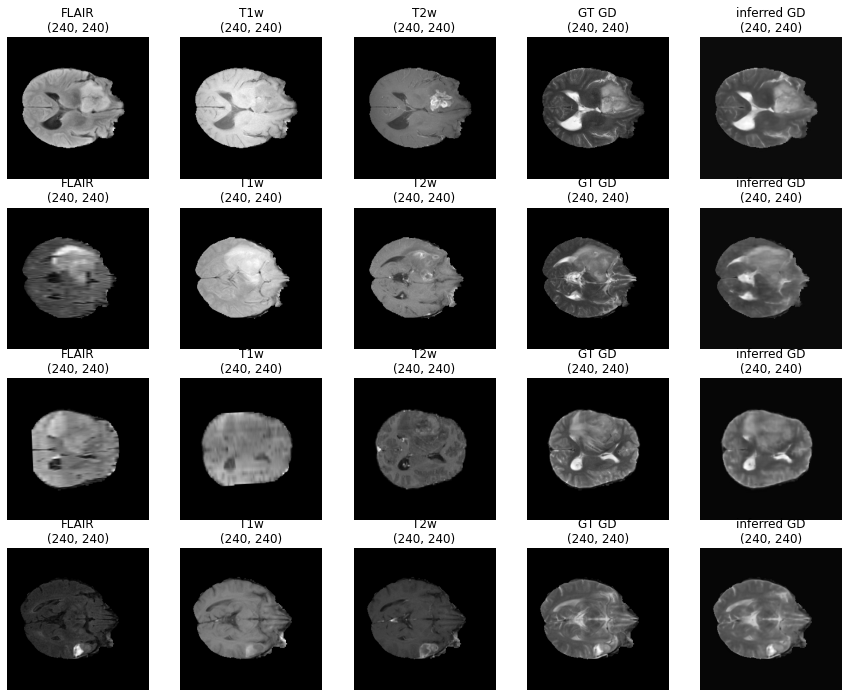

In [20]:
inference_gan(model, num_data=4)

## evaluate from your pretrained model

in `saved` directory, we have pretrained model with XX epoches with same configuration
with `inference_epoch` function, load checkpoint and inference it. 

0.0011628126521827653


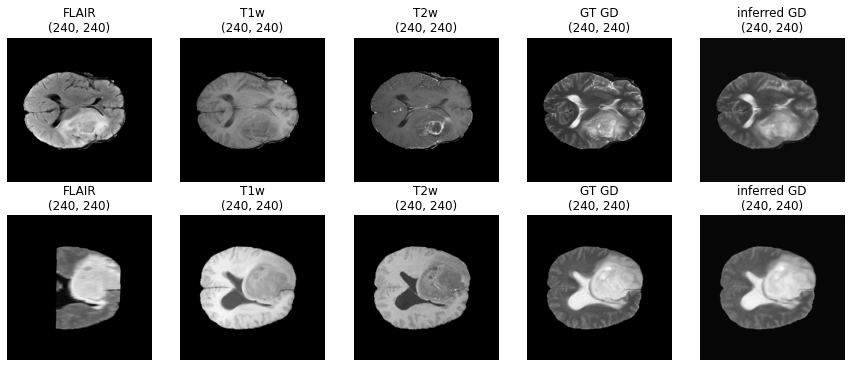

In [21]:
def inference_gan_epoch(work_dir, model,  prefix='ae1', epoch=10, num_data=2):
    import torch
    model.load_state_dict(torch.load(os.path.join(work_dir, "gan_{}_model_{:04d}.pth".format(prefix, epoch))))
    model.eval()
    inference_gan(model,   num_data)

model = Unet()
model.to(device)

inference_gan_epoch('../temp', model,  'ae1', 100, 2)
